notes on 2020.1.21:
- 23.5 k cases: rain coverage >= 10%, median threat score: 0.53
- 8.1 k cases: rain coverage >= 20%, median threat score: 0.61
- sampling 1 k cases from 23.5 casese for quick evalucation of parameter tuning

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta
import pandas as pd
import joblib
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data0 = pd.read_csv(csv_path)

/Users/jiang/github_all/rainymotion/docs/notebooks


In [3]:
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())
select = np.random.choice(23508, 100).astype(np.int16)
print(data0.loc[select, "threat"].median())

0.5406794466918944
0.5746352987170175
0.5254764504699503


In [4]:
%%time
#import collections 
#keys = collections.deque()
#keys.append(yday_str)
#key = keys.popleft()

time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt_threat = {}  # datetime: threat score

model = models.Dense60()
daily_database = {}

inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
select = np.random.choice(23508, 100).astype(np.int16)
select.sort()
select_threat = []
per_threat = []
for i in select:  
    dt =     datetime.strptime(data0.loc[i,"datetime"], '%Y-%m-%d %H:%M:%S')
    dt_now = dt + timedelta(seconds = time_step)
    dt_12  = dt + timedelta(seconds = time_step * 13)
    yday_str = dt.strftime('%Y_%m_%d')    
    yday_now = dt_now.strftime('%Y_%m_%d')
    yday_12 =  dt_12.strftime('%Y_%m_%d')

    if yday_str not in daily_database:
        daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib"))
    if yday_12 not in daily_database:
        daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) 
    
    inputs[0,:,:] = daily_database[yday_str][int(dt.hour*12     + (dt.minute)/5)]/10.0   # back to original scale
    inputs[1,:,:] = daily_database[yday_now][int(dt_now.hour*12 + (dt_now.minute)/5)]/10.0
    gt_in_60_min =   daily_database[yday_12][int(dt_12.hour*12  + (dt_12.minute)/5)]/10.0
    model.input_data = inputs
    nowcast = model.run()  
    select_threat.append(metrics.CSI(gt_in_60_min, nowcast, threshold = threshold))
    per_threat.append(metrics.CSI(gt_in_60_min, inputs[1,:,:], threshold = threshold)) 
# Wall time: 1 min

CPU times: user 5min 10s, sys: 27.3 s, total: 5min 37s
Wall time: 1min 39s


## convert to panda dataframe and do data analysis

In [5]:
data = data0.loc[select,:]
data['threat_new']  = select_threat
data['threat_per']  = per_threat
np.median(data.threat),np.median(data.threat_new), np.median(data.threat_per)

(0.5188623605156424, 0.5198223527277954, 0.45801667341009916)

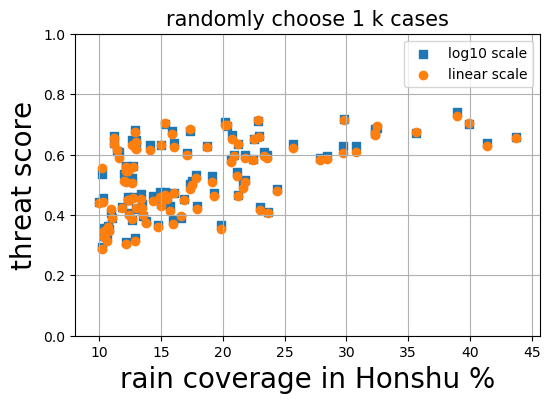

In [14]:
plt.figure(dpi=100)
plt.scatter(data.coverage, data.threat_new, marker = 's', label = "log10 scale")
plt.scatter(data.coverage, data.threat, marker = 'o',label = "linear scale")
plt.legend()
plt.title("randomly choose 1 k cases",fontsize= 15)
plt.xlabel("rain coverage in Honshu %",fontsize= 20)
plt.ylabel("threat score",fontsize= 20)
plt.ylim([0,1])
plt.grid()
plt.show()

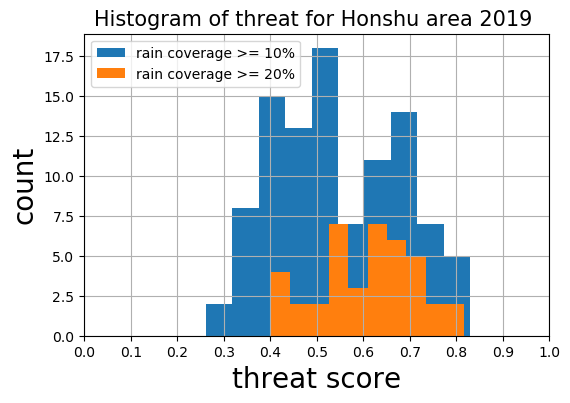

In [27]:
plt.figure(dpi = 100)
plt.hist(data.threat_new,10, label = "rain coverage >= 10%")
plt.hist(data.threat_new[data.coverage >= 20],10, label = "rain coverage >= 20%")
plt.legend()
plt.title("Histogram of threat for Honshu area 2019 ",fontsize= 15)
plt.xlabel("threat score",fontsize= 20)
plt.ylabel("count",fontsize= 20)
plt.xticks(np.linspace(0,1,11))
plt.xlim([0,1])
plt.grid()
plt.show()